In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  ftcw['abs'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

cp4_precip_hist = ftcw['prcp_hist']

ltag = ''

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.7019625512319937
TCW scaling [1.19938758 1.19938758 1.104523   1.17877165 1.17111967 1.15693016
 1.08019338 1.16968217 1.09620372 1.28048504 1.18748565 1.22224398
 1.19137074 1.24554717 1.22338062 1.23320867 1.31619694 1.2043598
 1.32834691 1.20466736]


In [27]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc')

cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc')
cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc')
cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc')
cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc')

In [28]:
cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
cp4_shear_fut = cp4_u925_fut-cp4_u600_fut

In [29]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [30]:
cmip_shear_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/u*.nc', concat_dim='model_name', combine='by_coords').load()

In [31]:
box = [-19,17,3.5,22]

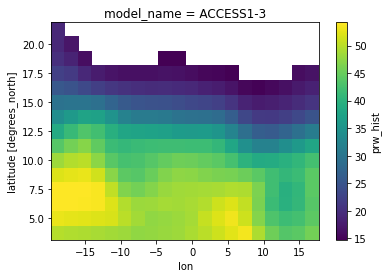

In [32]:
cmip_tcw_map['prw_hist'].sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]), model_name='ACCESS1-3').plot()

In [33]:
ds_merge = xr.merge([cmip_tcw_map, cmip_shear_map])

In [34]:
ds_merge = ds_merge

In [35]:
ds_merge

<xarray.Dataset>
Dimensions:       (lat: 25, lon: 27, model_name: 38)
Coordinates:
  * model_name    (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon           (lon) float64 -24.38 -22.5 -20.62 -18.75 ... 20.62 22.5 24.38
Data variables:
    prw           (model_name, lat, lon) float64 13.08 13.08 13.04 ... nan nan
    prw_hist      (model_name, lat, lon) float64 39.04 38.67 38.36 ... nan nan
    unknown       (model_name, lat, lon) float64 3.048 3.147 3.187 ... nan nan
    unknown_hist  (model_name, lat, lon) float64 1.485 1.618 1.808 ... nan nan

In [36]:
model_names = ds_merge.model_name

In [37]:
model_names

<xarray.DataArray 'model_name' (model_name: 38)>
array(['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5',
       'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0',
       'CanESM2', 'FGOALS-g2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G',
       'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC',
       'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR',
       'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR',
       'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME',
       'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4'], dtype=object)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'

In [38]:
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
cp4_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_hist)
cp4f_tcw_onCmip = ds_merge.salem.lookup_transform(cp4_tcw_fut)

In [39]:
cp4f_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_fut)
cp4_shear_onCmip = ds_merge.salem.lookup_transform(cp4_shear_hist)

In [66]:
obs_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

mdomain = [-11,16,4,25]

def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9
    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]

    return dicout

obs_mcs = calc_mcs_stuff(obs_mcs, mdomain)
cp4hist_mcs = calc_mcs_stuff(cp4hist_mcs, mdomain)
cp4fut_mcs = calc_mcs_stuff(cp4fut_mcs, mdomain)

In [67]:
mcs_gridded = cp4_tcw_onCmip['tcwv']
def add_lonlat_todic(dic,grid):
    try:
        del dic['grid_lon']
        del dic['grid_lat']
    except:
        pass
    grid_lon = []
    grid_lat = []
    for lonx, laty in zip(dic.lon, dic.lat):
        point = grid.sel(lat=laty, lon=lonx, method='nearest') #, tolerance=0.9

        grid_lat.append(float(point.lat.values))
        grid_lon.append(float(point.lon.values))
    dic['grid_lon'] = grid_lon
    dic['grid_lat'] = grid_lat

In [96]:
add_lonlat_todic(cp4hist_mcs, mcs_gridded)
add_lonlat_todic(cp4fut_mcs, mcs_gridded)

In [97]:
def assign_to_grid(dic, grid, var):
    mcs_array = np.zeros_like(grid.values)*np.nan
    tcw_array = np.zeros_like(grid.values)*np.nan
    shear_array = np.zeros_like(grid.values)*np.nan
    for yy, lat in enumerate(grid.lat):
        for xx, lon in enumerate(grid.lon):
            
            posi = np.where((dic['grid_lon']==lon) & (dic['grid_lat']==lat))
            precip = np.array(dic[var])[posi]
            tcw = np.array(dic['tcwv'])[posi]
            shear = np.array(dic['shear'])[posi]
            ppos = np.where(precip>0.1)
            valid = np.sum(precip>0.1)
            
            precip = precip[ppos]
            tcw = tcw[ppos]
            shear = shear[ppos]

            try:

                tperc = np.percentile(tcw, 95)
                sperc = np.percentile(shear, 95)
                perc = np.percentile(precip, 95)  #[(tcw > tperc) & (tcw<tttperc)]

######################################

#                 tcw95 = np.percentile(tcw, 95)
#                 tcw99 = np.percentile(tcw, 99.9)
        
#                 shear95 = np.percentile(shear, 95)
#                 shear99 = np.percentile(shear, 99.9)

#                 tperc = np.median(tcw[(tcw>=tcw95) & (tcw<=tcw99)])
#                 sperc = np.median(shear[(shear>=shear95) & (shear<=shear99)])
                
#                 perc = np.percentile(precip[(tcw>=tcw95) & (tcw<=tcw99)], 95)  #[(tcw > tperc) & (tcw<tttperc)]
            
            except:
                perc = np.nan
                tperc = np.nan
                sperc = np.nan
            if valid < 5:
                perc=np.nan
            mcs_array[yy,xx] = perc
            tcw_array[yy,xx] = tperc
            shear_array[yy,xx] = sperc
    outarr = grid.copy(deep=True)
    tarr = grid.copy(deep=True)
    sarr = grid.copy(deep=True)
    outarr.values = mcs_array
    tarr.values = tcw_array
    sarr.values = shear_array
    return outarr, tarr, sarr  

In [98]:
cp4_mcs_grid, cp4_tcw_grid,cp4_shear_grid = assign_to_grid(cp4hist_mcs,mcs_gridded, 'prcp')
cp4f_mcs_grid, cp4f_tcw_grid,cp4f_shear_grid = assign_to_grid(cp4fut_mcs,mcs_gridded, 'prcp')

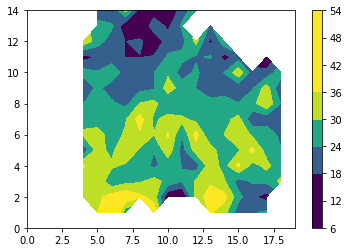

In [102]:
plt.contourf(cp4f_mcs_grid-cp4_mcs_grid, vmin=15, vmax=35)
plt.colorbar()


In [89]:
tcwvfac_all

array([1.19938758, 1.19938758, 1.104523  , 1.17877165, 1.17111967,
       1.15693016, 1.08019338, 1.16968217, 1.09620372, 1.28048504,
       1.18748565, 1.22224398, 1.19137074, 1.24554717, 1.22338062,
       1.23320867, 1.31619694, 1.2043598 , 1.32834691, 1.20466736])

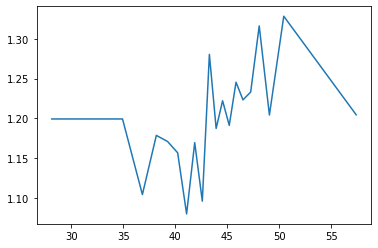

In [94]:
plt.plot(ftcw['tcw_hist'], tcwvfac_all)

In [109]:
np.median(ftcw['tcw_hist'])

43.614999999999995

In [110]:
cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
cp4_pcp_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
fmed = np.median(ftcw['tcw_hist'])
ffirst = np.mean(tcwvfac_all[0:int(np.round(len(ftcw['tcw_hist'])/2,0))])
flast = np.mean(tcwvfac_all[int(np.round(len(ftcw['tcw_hist'])/2,0))::])

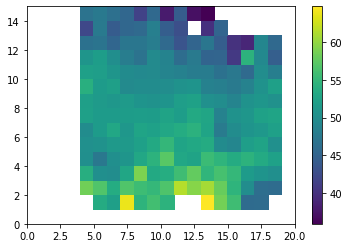

In [117]:
plt.pcolormesh(cp4_tcw_grid.values)
plt.colorbar()

In [118]:
np.mean(tcwvfac_all)

1.1996745900023602

In [119]:


for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        pix = cp4_tcw_grid.values[y,x]#cp4_tcw_onCmip['tcwv'].values[y,x]
        if pix < np.min(ftcw['tcw_hist'])-1:
            continue
        if pix > np.max(ftcw['tcw_hist'])+3:
            continue
            
        try:
            if pix < fmed:
                out = ffirst
            else: 
                out = flast
        except ValueError:
            #cp4_pos_array[y,x] = np.nan
            continue
        cp4_pos_array[y,x] = out

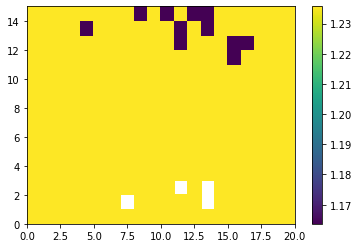

In [125]:
plt.pcolormesh(cp4_pos_array)
plt.colorbar()

In [126]:
np.unique(cp4_pos_array)

array([1.1636684, 1.2356808,       nan,       nan,       nan,       nan],
      dtype=float32)

In [121]:
def percentile_contribution(p90, ds_merge):
    contr = p90.copy(deep=True)
    fillarr = np.zeros_like(p90.values)*np.nan

    for latid, lats in enumerate(p90.lat):
        for lonid, lons in enumerate(p90.lon):

            ds = ds_merge.sel(lat=lats, lon=lons)

            if np.isnan(p90.sel(lat=lats, lon=lons).values):
                continue
            
            pos = np.where(p90.sel(lat=lats, lon=lons).values == ds['sum'].values)
           # ipdb.set_trace()
            try:
                #ipdb.set_trace()
                ctr = ds['contribution'].isel(model_name=pos[0]).values
                fillarr[latid, lonid] = ctr
            except:
                print('Error')
                continue
    contr.values = fillarr
    return contr

In [132]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [123]:
def draw_map(ax, dat, lat, lon, title='', levels=None, cbarlabel='', cmap='', bl=False, ll=True, boxlabel=False):
    import matplotlib.ticker as mticker
    
    ax.set_facecolor('lightgrey')
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, alpha=0.7, extend='both')
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.contour(lon, lat, dat, transform=ccrs.PlateCarree(), colors='white', levels=levels, linewidths=0.1)
    ax.coastlines()
    #Gridlines
    xl = ax.gridlines(draw_labels=True, linestyle='dotted', linewidths=0.001);
    xl.top_labels = False
    xl.right_labels = False
    xl.bottom_labels = bl
    xl.left_labels = ll
    xl.ylocator = mticker.FixedLocator([6, 9, 12,15,18])
    xl.xlocator = mticker.FixedLocator([-15, -10,-5,0,5,10,15])
    #xl.grid(False)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', linewidth=0.5);
    plt.title(title, fontsize=10)
    
    ax.set_ylim(3.7,21)
    ax.set_xlim(-17.5,16)

#     ax.set_ylim(9,19)
#     ax.set_xlim(-10,15)
    
    x=2
    y=1.1
    ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
    niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
    timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
    

    
    rect1 = patches.Rectangle((-10,9),25,10,linewidth=1.5,edgecolor='k',facecolor='none', zorder=98)

    ax.add_patch(rect1)

    
    if boxlabel:
        plt.text(-3.42,12.65, '1', fontsize=8, color='w')
        plt.text(0.195,13.9, '2', fontsize=8, color='w')
        plt.text(-4.85,17, '3', fontsize=8, color='w')
        
        plt.text(-8,13, 'Mali', fontsize=8, color='k')
        plt.text(-3.46,11.8, 'Burkina Faso', fontsize=8, color='k')
        plt.text(6,15.5, 'Niger', fontsize=8, color='k')
        plt.text(7,11, 'Nigeria', fontsize=8, color='k')
        

        ax.plot(-1.52, 12.38, marker='o',  color='w', linestyle='', markersize=1)  #transform=ax.transAxes,
        ax.plot(2.13, 13.5, marker='o',  color='w', linestyle='', markersize=1)
        ax.plot(-3, 16.8, marker='o',  color='w', linestyle='', markersize=1)


    
        rect2 = patches.Rectangle((ouaga[0],ouaga[2]),ouaga[1]-ouaga[0],ouaga[3]-ouaga[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        rect3 = patches.Rectangle((niamey[0],niamey[2]),niamey[1]-niamey[0],niamey[3]-niamey[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        rect4 = patches.Rectangle((timbuktu[0],timbuktu[2]),timbuktu[1]-timbuktu[0],timbuktu[3]-timbuktu[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
        ax.add_patch(rect2)
        ax.add_patch(rect3)
        ax.add_patch(rect4)



In [124]:
cp4_tcw_onCmip

<xarray.Dataset>
Dimensions:  (lat: 15, lon: 20)
Coordinates:
  * lon      (lon) float64 -18.75 -16.88 -15.0 -13.12 ... 11.25 13.12 15.0 16.88
  * lat      (lat) float64 3.75 5.0 6.25 7.5 8.75 ... 17.5 18.75 20.0 21.25
Data variables:
    tcwv     (lat, lon) float32 43.118347 43.26831 ... 16.884636 14.405639
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0, 4, 'd')

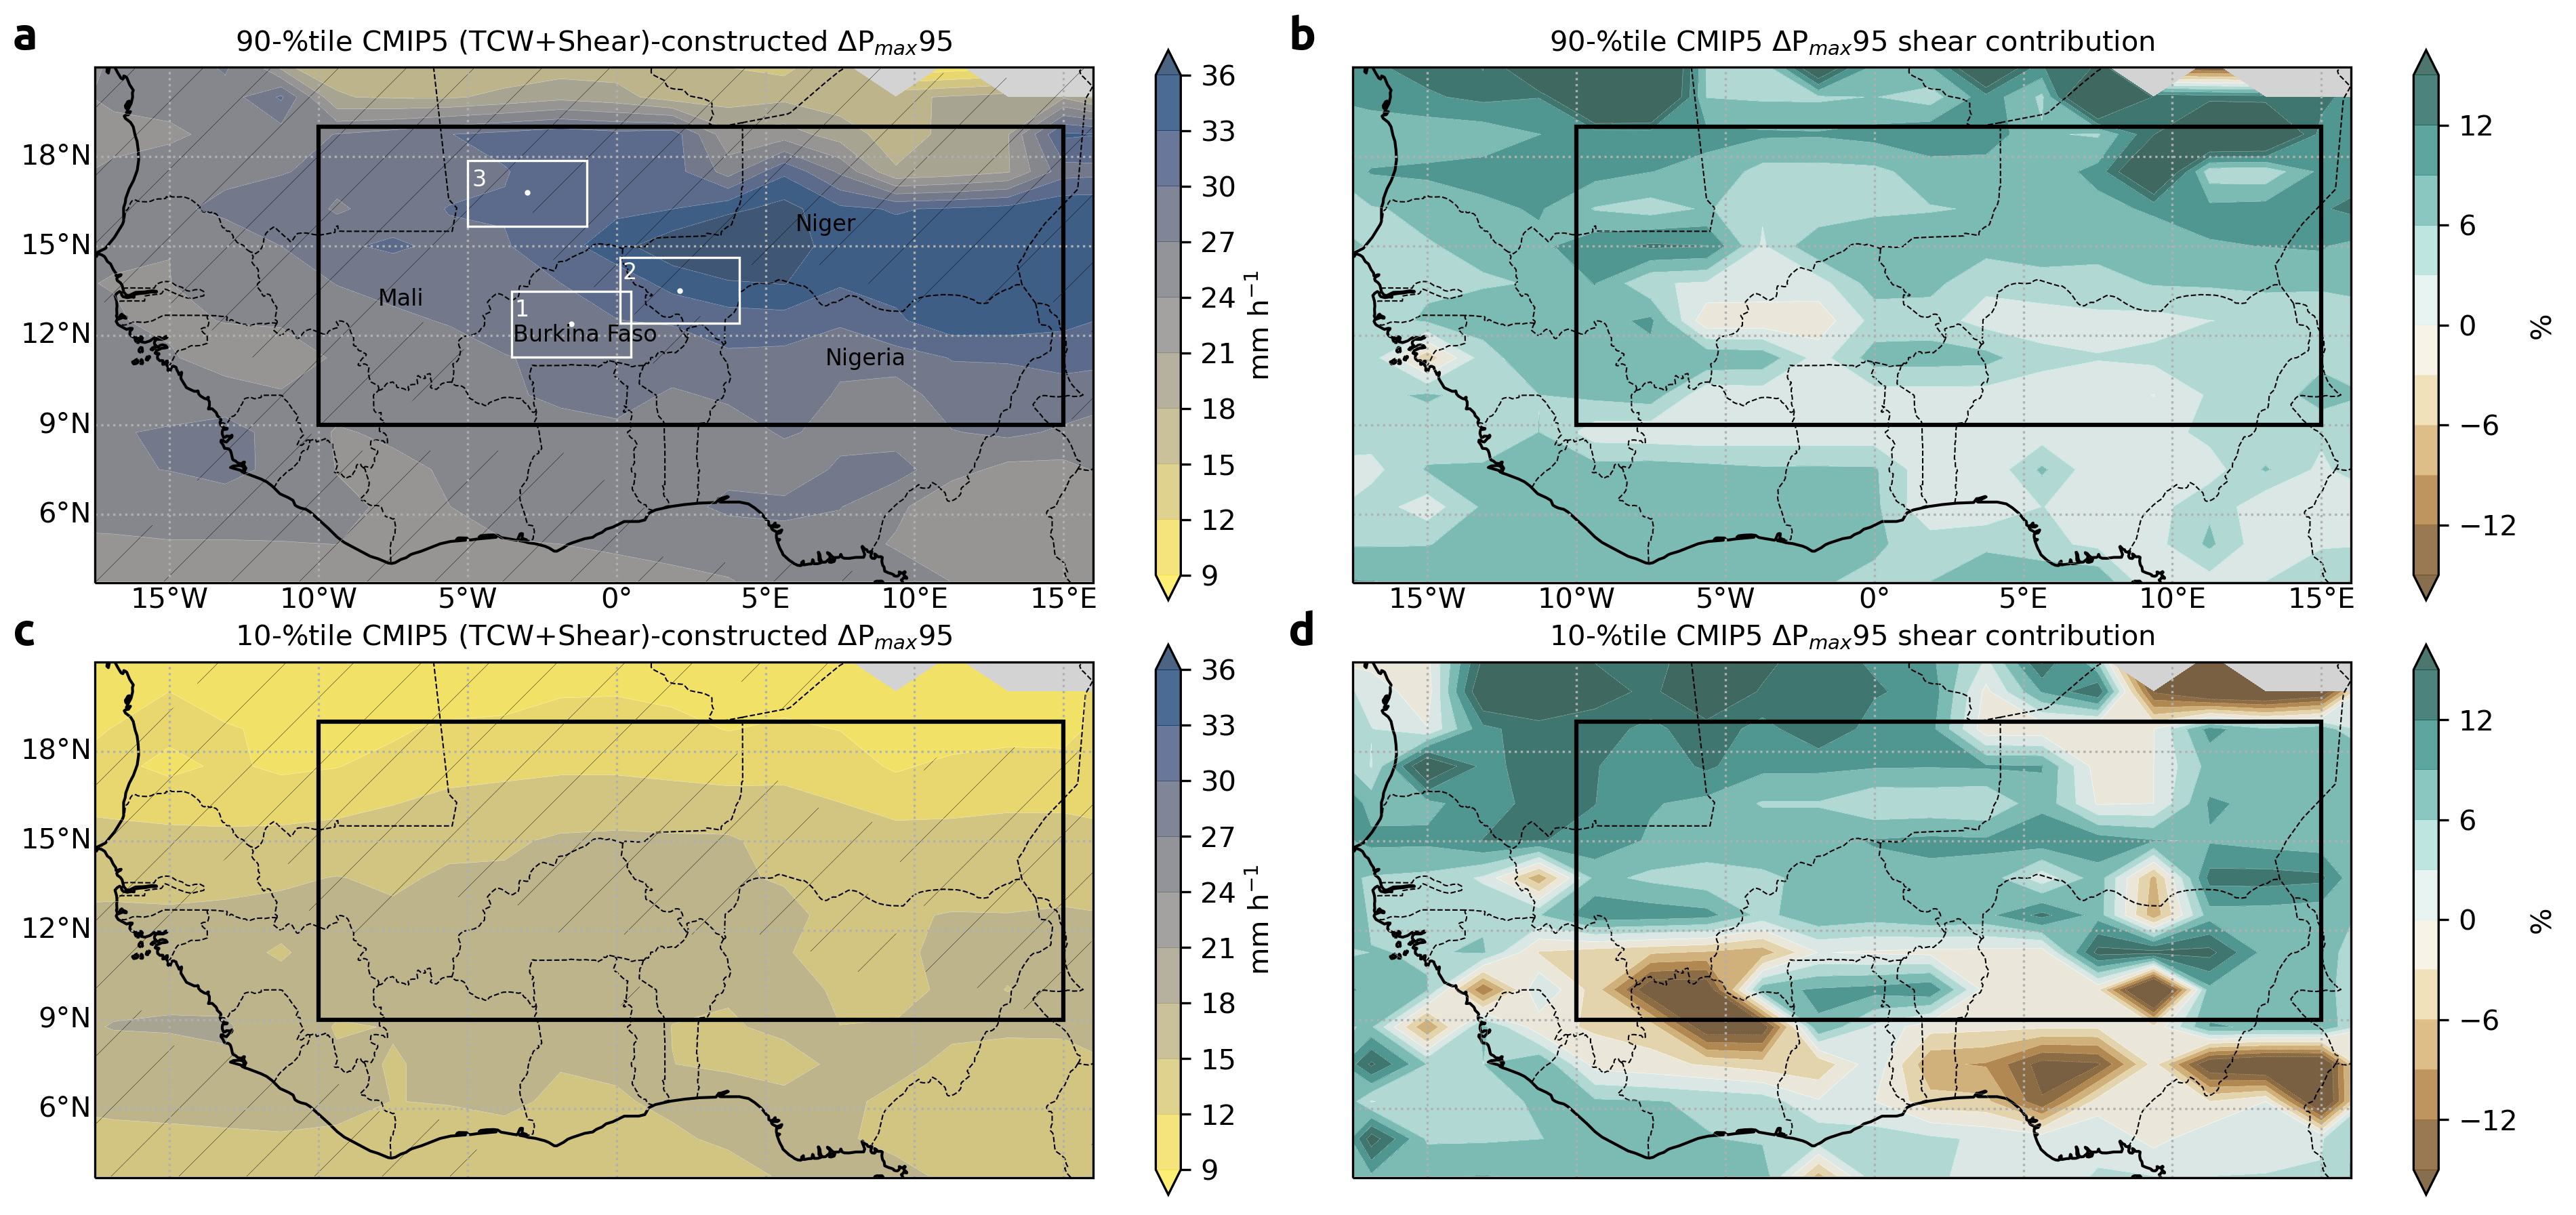

In [159]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
mpl.rcParams['hatch.color'] = 'k'  # previous pdf hatch linewidth
lats = cp4_tcw_onCmip.lat.values

#############################################################
#f = plt.figure(figsize=(12.5,7), dpi=300)
f = plt.figure(figsize=(12.5,6), dpi=300)

slevels=np.arange(-15,16,3)

tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
##relative CMIP change
ds_shear = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw']/ds_merge['prw_hist']).where(ds_merge['prw_hist']>21.5)

ar_list = []
for mids in ds_merge['prw'].model_name:
   
    new_ar_list =  cmip_rel.sel(model_name=mids) * cp4_tcw_onCmip['tcwv'] * 1.2356808#np.mean(tcwvfac_all)
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)

ds_scaled = xr.concat(ar_list, dim='model_name')
ds_merge['sum'] =  ds_shear +ds_scaled  #
ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)



ax = f.add_subplot(2,2,2, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 
cont = gauss(contr10.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=5, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])

tag='90'
ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True, boxlabel=True) 
cont = gauss(contr90.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=5, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])


for yy in ['2040','2060', '2080']:
    box = niamey
    tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
    sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
    cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')
    
        cp4_tcw_hist = cp4_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
        cp4_tcw_fut = cp4f_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
        cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
    
        cp4_shear_abs = ((cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])).sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    

ax1 = f.add_subplot(2,2,3, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)



ax1 = f.add_subplot(2,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)

plt.tight_layout()

f.subplots_adjust(left=0.001)

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.5

plt.annotate(text[0], xy=(x1, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.46), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.46), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[4], xy=(x1, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[5], xy=(x2, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)



#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2080_absolute_CP4_0.1mm_locScaling_posPrcp'+str(yy)+'_small.jpg')

In [ ]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
mpl.rcParams['hatch.color'] = 'k'  # previous pdf hatch linewidth
lats = cp4_tcw_onCmip.lat.values

#############################################################
#f = plt.figure(figsize=(12.5,7), dpi=300)
f = plt.figure(figsize=(12.5,6), dpi=300)

slevels=np.arange(-15,16,3)

tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
##relative CMIP change
ds_shear = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw']/ds_merge['prw_hist']).where(ds_merge['prw_hist']>21.5)

ar_list = []
for mids in ds_merge['prw'].model_name:
   
    new_ar_list =  cmip_rel.sel(model_name=mids) * cp4_tcw_onCmip['tcwv'] * 1.2356808#np.mean(tcwvfac_all)
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)

ds_scaled = xr.concat(ar_list, dim='model_name')
ds_merge['sum'] =  ds_shear +ds_scaled  #
ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(2,2,3, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 
cont = gauss(contr10.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=5, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])

ax1 = f.add_subplot(2,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)


tag='90'
ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True, boxlabel=True) 
cont = gauss(contr90.values,0.75)
ax.contourf(ds_merge.lon.values, ds_merge.lat.values, cont>=5, transform=ccrs.PlateCarree(), colors='none', hatches='/', levels=[0.5,1])
#ax.contour(ds_merge.lon.values, ds_merge.lat.values, cont, colors='grey', linewidths=2, transform=ccrs.PlateCarree(), levels=[6,50])


ax1 = f.add_subplot(2,2,2, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)

plt.tight_layout()

f.subplots_adjust(left=0.001)

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.5

plt.annotate(text[0], xy=(x1, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.46), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.46), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[4], xy=(x1, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[5], xy=(x2, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)



#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2080_absolute_CP4_0.1mm_locScaling_posPrcp'+str(yy)+'_small.jpg')

In [49]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
model_names = cmip_tcw_map.model_name
tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2020-2100/prw_*.nc')[0]).squeeze()

In [50]:
cmip_tcw_map

<xarray.Dataset>
Dimensions:     (lat: 25, lon: 27, model_name: 38)
Coordinates:
  * model_name  (model_name) object 'ACCESS1-0' 'ACCESS1-3' ... 'inmcm4'
  * lat         (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon         (lon) float64 -24.38 -22.5 -20.62 -18.75 ... 20.62 22.5 24.38
Data variables:
    prw         (model_name, lat, lon) float64 13.08 13.08 13.04 ... nan nan nan
    prw_hist    (model_name, lat, lon) float64 39.04 38.67 38.36 ... nan nan nan

In [51]:
def calc_mcs(dd):

    obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
    cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
    cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

    obs_mcs95 = calc_mcs_stuff(obs_mcs_d, dd).quantile(0.95)
    cp4hist_mcs95 = calc_mcs_stuff(cp4hist_mcs_d, dd).quantile(0.95)
    cp4fut_mcs95 = calc_mcs_stuff(cp4fut_mcs_d, dd).quantile(0.95)
    
    return cp4hist_mcs95, cp4fut_mcs95, obs_mcs95

In [52]:
def calc_mcs_stuff(dic, domain):
    m1=7
    m2=9

    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=0.1) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    
    return dicout

In [53]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

28.541301311823233 13.51199221924733


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

34.40939799739998 19.806870290754567


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

33.98623540989118 21.783544724528685


Text(0, 4, 'c')

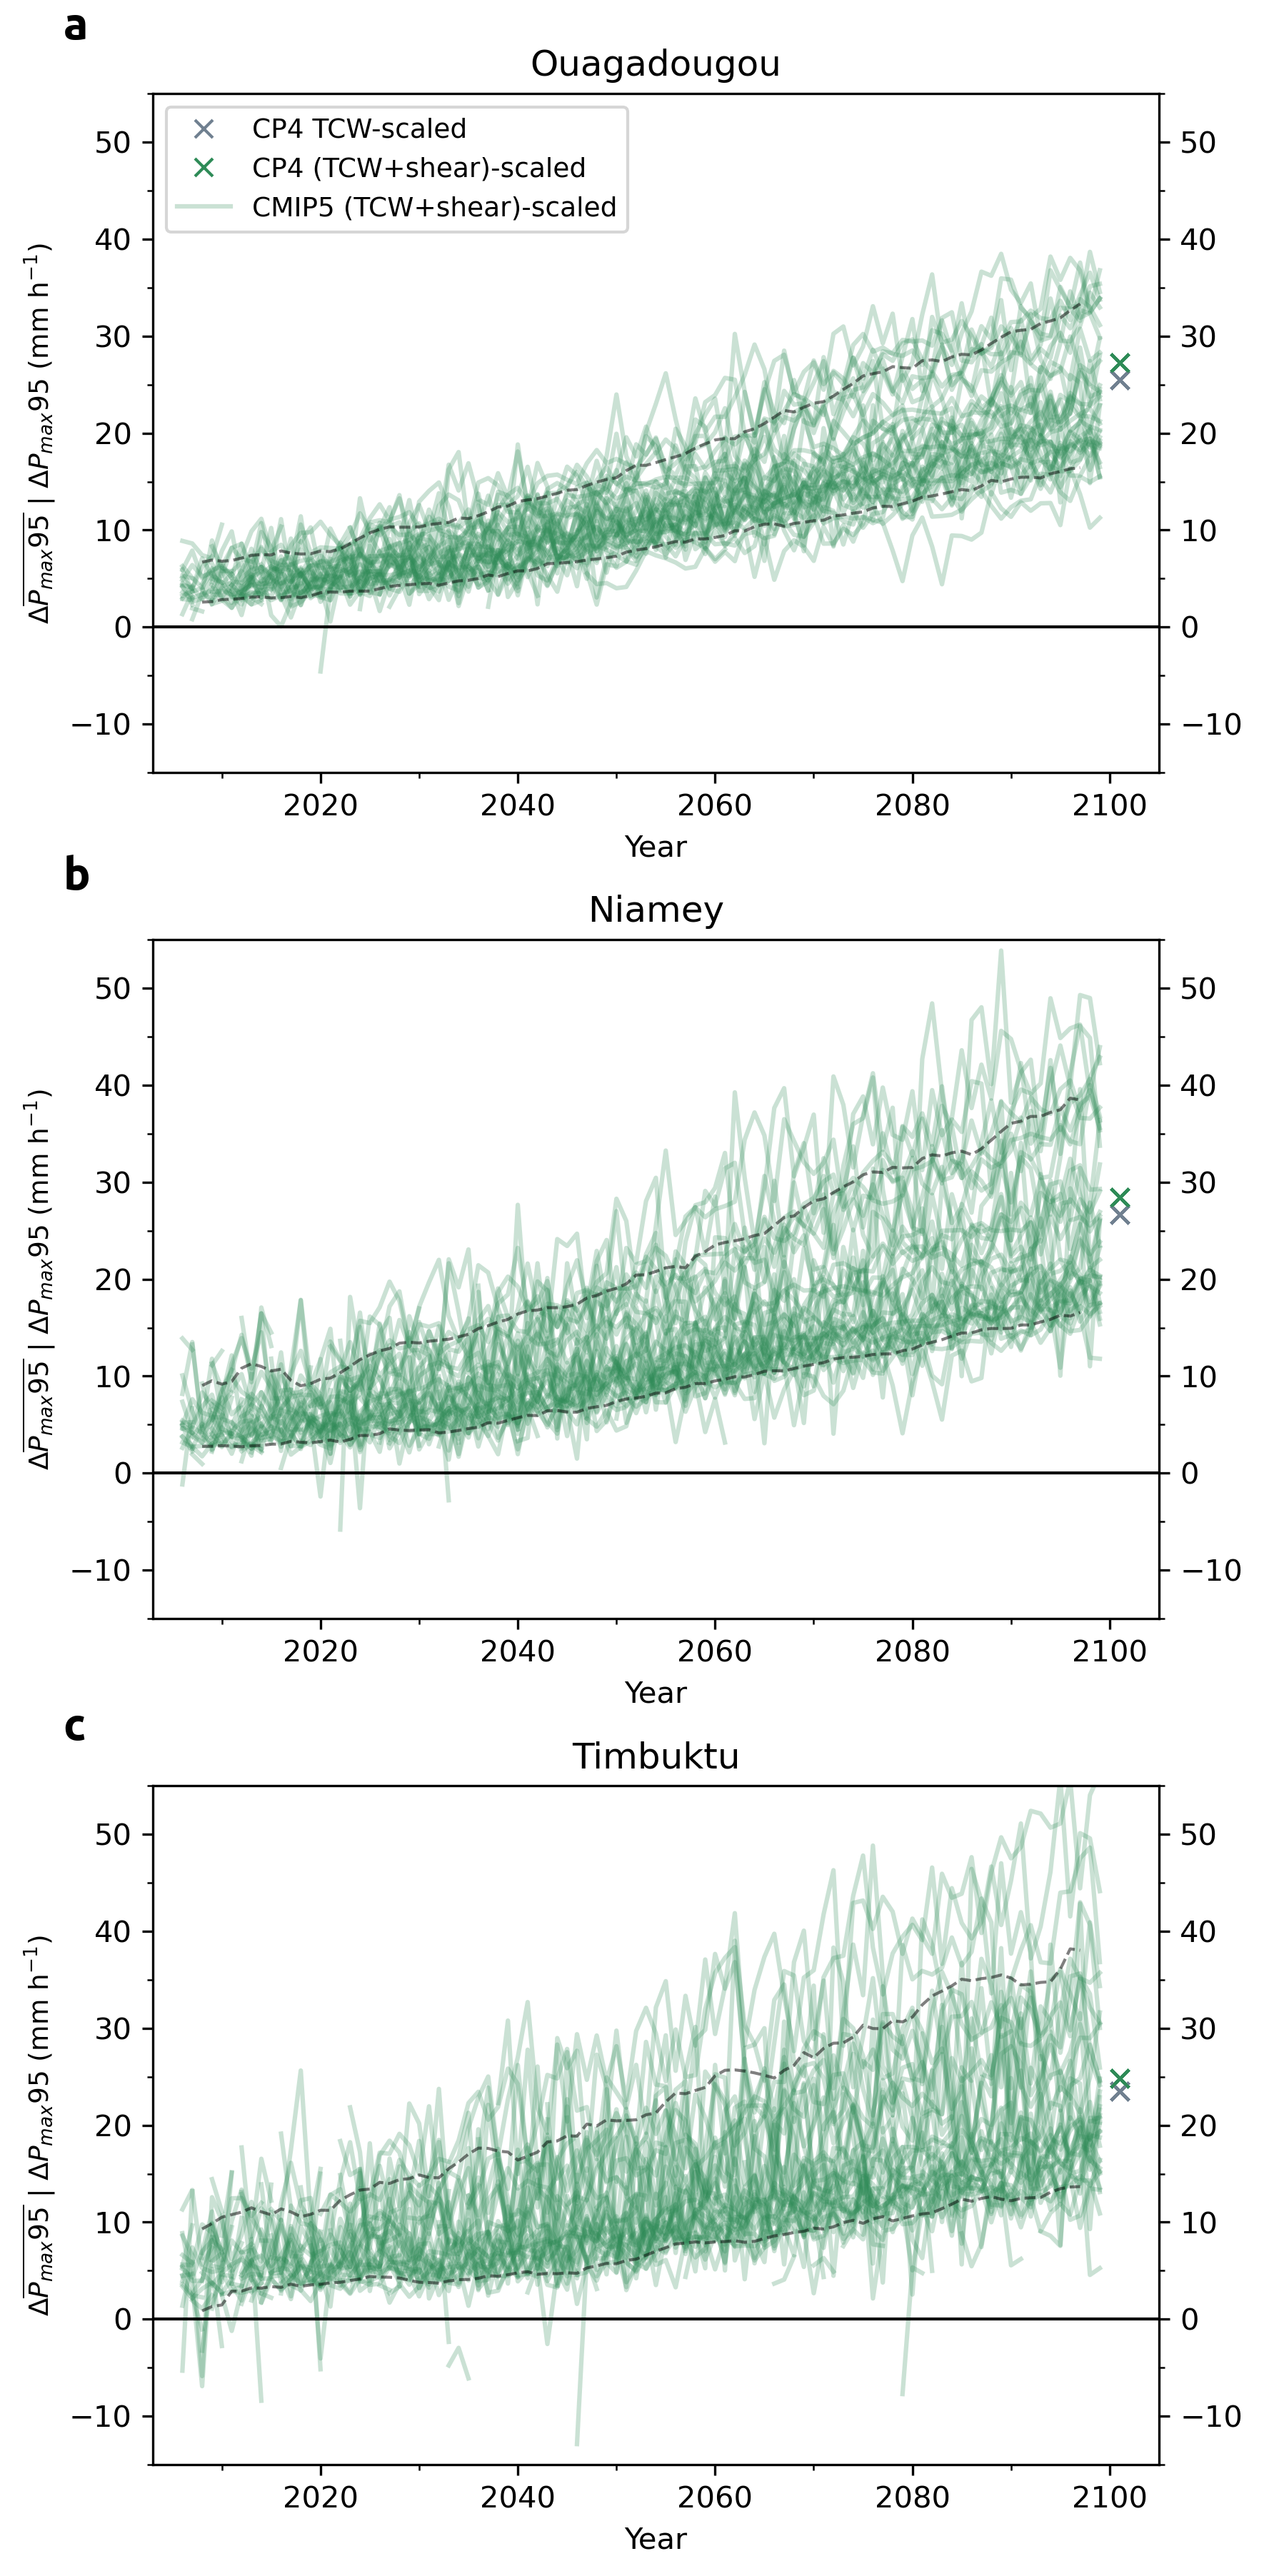

In [56]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,12), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['abs']) 

    dirs = regions
    #cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    #cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])
    
    cp4_tcw_hist = cp4_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    cp4_tcw_fut = cp4f_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
    
    cp4_shear_abs = ((cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])).sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    #evenly_spaced_interval = np.linspace(0, 1, len(model_names))

    #colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    cmiparr = np.zeros((len(model_names.values), len(np.unique(tcw_map['time.year'].values))))
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)

        new_ar_list95 = cmip_rel * cp4_tcw_hist * np.mean(tcwvfac_all)
        sums95 = new_ar_list95 + ds_shear 
        
        cp4construct95 =  cp4_tcw_rel * cp4_tcw_hist * np.mean(tcwvfac_all)
        cp4construct95min =  cp4_tcw_rel * cp4_tcw_hist * np.min(tcwvfac_all)
        cp4construct95max =  cp4_tcw_rel * cp4_tcw_hist * np.max(tcwvfac_all)

        cp4total95 = cp4construct95 + cp4_shear_abs*shearfac
        cp4total95min = cp4construct95min + cp4_shear_abs*shearfac
        cp4total95max = cp4construct95max + cp4_shear_abs*shearfac
        
        #ipdb.set_trace()
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        try:
            cmiparr[ids:len(sums95)] = sums95
        except:
            ipdb.set_trace()

        #ax.plot(2101, cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'], marker='X', linestyle='', mfc='k', label=r'CP4 modelled $\Delta P_{max}95_{local}$', zorder=99, mec='none')
        ax.plot(2101, cp4construct95, marker='x', linestyle='', color='slategrey', label=r'CP4 TCW-scaled')
        ax.plot(2101, cp4total95, marker='x', linestyle='', color='seagreen', label=r'CP4 (TCW+shear)-scaled')

        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+shear)-scaled')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
        #ipdb.set_trace()   
#         if rname == 'timbuktu':
#             ipdb.set_trace()
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
    c10, c90 = np.nanpercentile(cmiparr, [10,90], axis=0)
    c10rolling = moving_average(c10, 5)
    c90rolling = moving_average(c90,5)
    yrolling = moving_average(tcw_map['time.year'].values, 5)

    ax.plot(yrolling,c10rolling, color='k', alpha=0.5, linewidth=1, linestyle='dashed')
    ax.plot(yrolling,c90rolling, color='k', alpha=0.5, linewidth=1, linestyle='dashed')
    
    
    print(np.median(tsordered[pos90][-30::]), np.median(tsordered[pos90][-30::])-np.median(tsordered[pos10][-30::]))
    

    #ax.text(2065,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_mcs95['tcwv'],2)), fontsize=8)
   # ax.text(2065,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95['prcp'],2)), fontsize=8)
   # ax.text(2065,-13.7,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,55)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm_sahel_boxes_rolling.jpg')

In [ ]:
ftcw['tcw_hist']

In [ ]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,11), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 
    precip_all = ftcw['prcp_hist']

    dirs = regions
    #cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    #cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])

    cp4_tcw_hist = cp4_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    cp4_tcw_fut = cp4f_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
    
    cp4_shear_abs = ((cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])).sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    
    if rname=='niamey':
        c=1.5
    else:
        c=0
    cp4hist_mcs95 = cp4_mcs_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()-c
    cp4fut_mcs95 = cp4f_mcs_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    cp4hist_tcw95 = cp4_tcw_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    isclose = np.nanargmin(np.abs(cp4hist_tcw95.values-ftcw['tcw_hist']))
    
#     cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(dirs[region][0])
#     isclose = np.nanargmin(np.abs(cp4hist_tcw95.values-ftcw['tcw_hist']))

    cp4_pos_array95 = tcwvfac_all[isclose]
    cp4_prcp_array95 = ftcw['prcp_hist'][isclose]
    cp4f_prcp_array95 = ftcw['prcp_fut'][isclose]

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    #evenly_spaced_interval = np.linspace(0, 1, len(model_names))
    #colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

        years = np.unique(tcw_map['time.year'].values)

        new_ar_list95 = cmip_rel *cp4_pos_array95 * cp4hist_mcs95
        sums95 = new_ar_list95 + ds_shear
        
        cp4construct95 =  cp4hist_mcs95 * cp4_pos_array95 * cp4_tcw_rel.values

        cp4total95 = cp4construct95 + cp4_shear_abs*shearfac
        
        #ipdb.set_trace()
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        model_Pmax = cp4fut_mcs95-cp4hist_mcs95+c

        ax.plot(2101, cp4fut_mcs95-cp4hist_mcs95, marker='X', linestyle='', mfc='k', label=r'CP4 modelled $\Delta P_{max}95$', zorder=99, mec='none')
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-scaled')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+shear)-scaled')

        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+shear)-scaled')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
        #ipdb.set_trace()   
        if ids == 0:
            print('CP-combined', cp4total95)
            print('constr-model', cp4total95-(cp4fut_mcs95-cp4hist_mcs95) )
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
  
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    
    print('CMIPPdifference', np.median(tsordered[pos90][-30::]), np.median(tsordered[pos90][-30::])-np.median(tsordered[pos10][-30::]))
    

    ax.text(2065,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_tcw95.values,2)), fontsize=8)
    ax.text(2065,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95.values,2)), fontsize=8)
    ax.text(2065,-13.7,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,55)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm_sahel_fromMap.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0, 4, 'f')

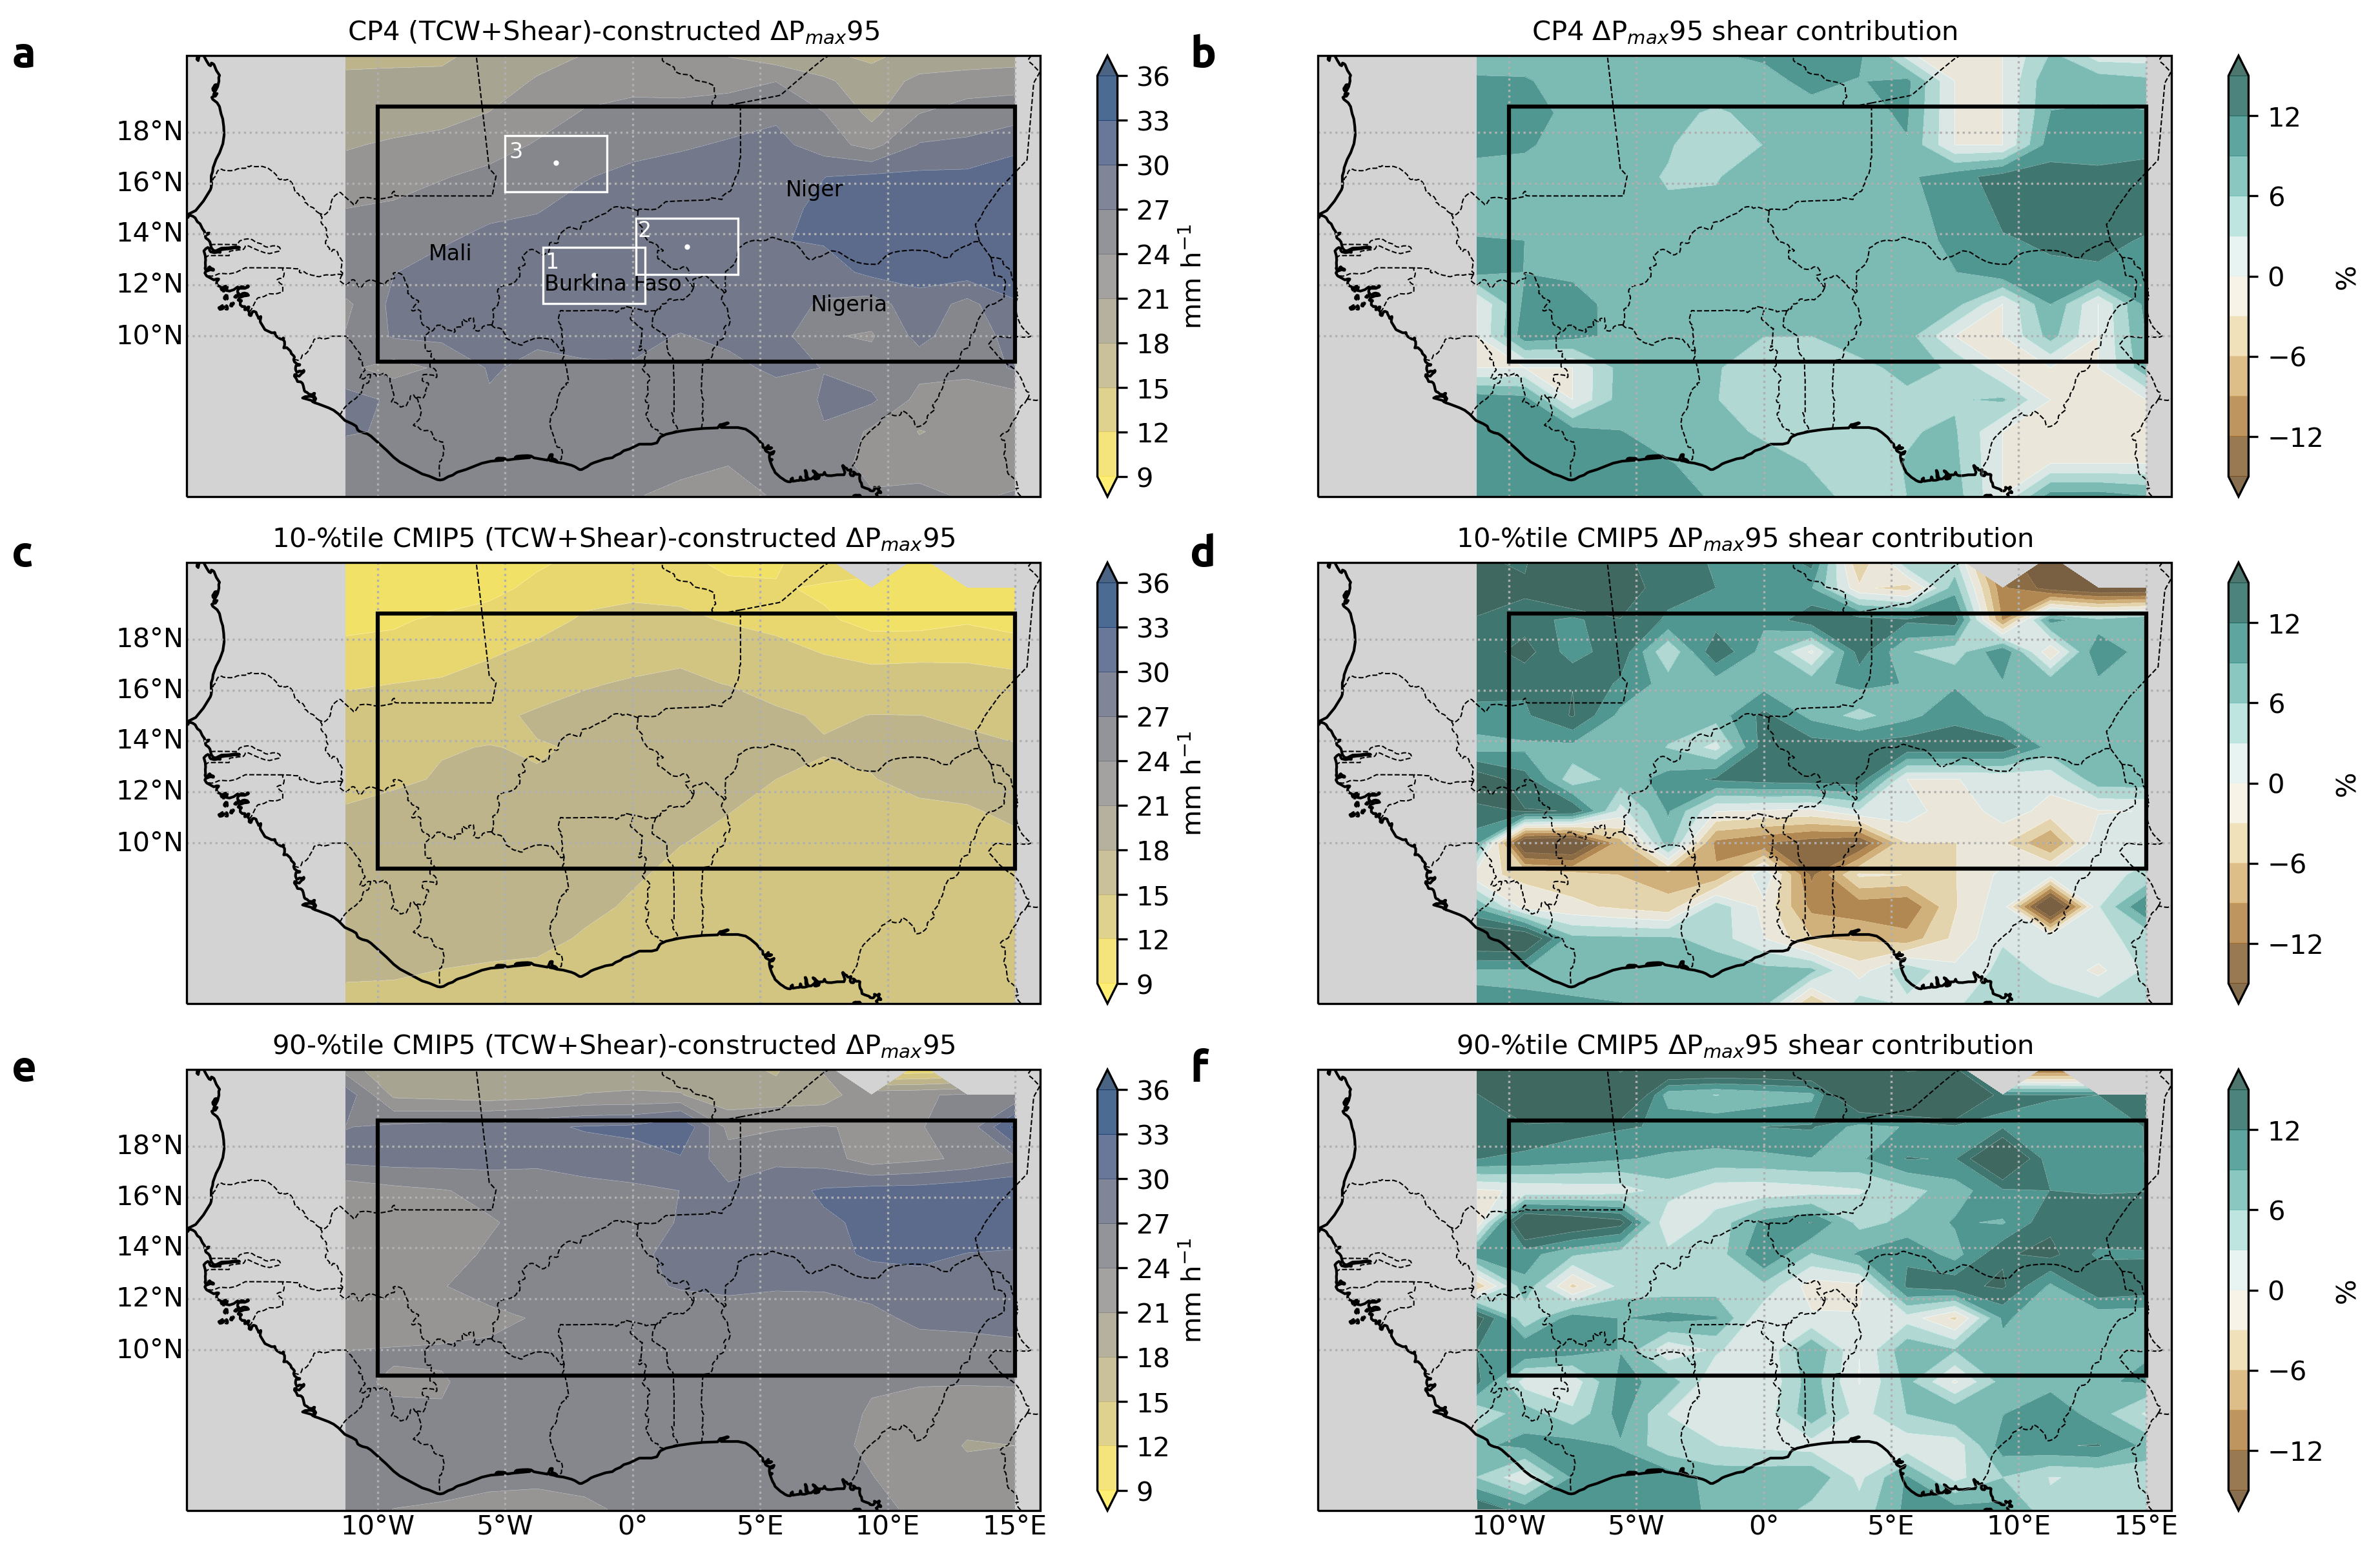

In [84]:
ftcw_timbuktu = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_timbuktu.p', "rb")) #'+region+'
ftcw_niamey = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_niamey.p', "rb")) #'+region+'
ftcw_ouaga = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors_ouaga.p', "rb")) #'+region+'
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'

cp4_pos_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
cp4_pcp_array = np.zeros_like(cp4_tcw_onCmip['tcwv'].values)*np.nan
lats = cp4_tcw_onCmip.lat.values

for x in range((cp4_tcw_onCmip['tcwv'].values).shape[1]):
    for y in range((cp4_tcw_onCmip['tcwv'].values).shape[0]):
        
#         if lats[y] <=13.3:
#             use_scal = ftcw_niamey
#         elif (lats[y] >13.3) & (lats[y] <16):
#             use_scal = ftcw_niamey
#         elif (lats[y] >=16):
#             use_scal = ftcw_timbuktu
#         else:
        use_scal = ftcw
        
        pix = cp4_tcw_grid.values[y,x]#cp4_tcw_onCmip['tcwv'].values[y,x]
        #ipdb.set_trace()
        if pix < np.min(use_scal['tcw_hist'])-1:
            continue
        if pix > np.max(use_scal['tcw_hist'])+3:
            continue
        #ipdb.set_trace()    
        try:
            isclose = np.nanargmin(np.abs(pix-use_scal['tcw_hist']))
        except ValueError:
            #cp4_pos_array[y,x] = np.nan
            continue
        cp4_pos_array[y,x] = use_scal['rel'][isclose] #[-2]#[
        cp4_pcp_array[y,x] = use_scal['prcp_hist'][isclose]

notfinite = np.isnan(cp4_pos_array)
#############################################################
#f = plt.figure(figsize=(12.5,7), dpi=300)
f = plt.figure(figsize=(12.5,8), dpi=300)


slevels=np.arange(-15,16,3)

ax = f.add_subplot(3,2,1, projection=ccrs.PlateCarree())
# pcp associated via tcw associated via climate vectors
p_tcw_change = (cp4f_tcw_onCmip['tcwv']-cp4_tcw_onCmip['tcwv']) * 1.24  #mcs_cp4_rel_tcw


p_shear_change = (cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])*shearfac #* gauss((cp4f_shear_grid.values-cp4_shear_grid.values),0.25)

p_shear_change.values[np.isnan(p_shear_change.values)] = 0
#shear_perc_contrib = p_shear_change/(p_shear_change+p_tcw_change_abs)*100
#ipdb.set_trace()
draw_map(ax, p_tcw_change+p_shear_change, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon, title='CP4 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=False, boxlabel=True) 
#draw_map(ax, p_tcw_change, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon, title='CP4 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=False, boxlabel=True)   #levels=np.arange(9,39,3)


ax1 = f.add_subplot(3,2,2, projection=ccrs.PlateCarree())  #cp4f_mcs_grid-gauss(cp4_mcs_grid,0.25) 

# p_prcp_change = gauss(cp4f_mcs_grid.values-cp4_mcs_grid.values,0.3) #(cp4f_mcs_grid- #gauss(((cp4f_prcp_onCmip-cp4_prcp_onCmip)/cp4_prcp_onCmip*100).values, 0.65)#gauss((cp4f_mcs_grid-cp4_mcs_grid)/cp4_mcs_grid*100,0.65) #gauss(cp4f_mcs_grid-cp4_mcs_grid,0.55)  #(cp4f_prcp_onCmip-cp4_prcp_onCmip) #(cp4f_mcs_grid-
# p_prcp_change[notfinite] = np.nan 
# draw_map(ax1, p_prcp_change, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon, title='CP4 modelled $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=False, ll=False)
draw_map(ax1, p_shear_change/(p_tcw_change+p_shear_change)*100, cp4f_tcw_onCmip.lat, cp4f_tcw_onCmip.lon,  title='CP4 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

tag='10'
yy ='2080'
tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*.nc', concat_dim='model_name', combine='by_coords').load()
sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*.nc', concat_dim='model_name', combine='by_coords').load()
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc')

ds_merge = xr.merge([tcw_map, sh_map])
ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
##relative CMIP change
ds_shear = ds_merge['unknown']*shearfac
cmip_rel = (ds_merge['prw']).where(ds_merge['prw_hist']>21.5)

ar_list = []
for mids in ds_merge['prw'].model_name:
   
    new_ar_list =   cmip_rel.sel(model_name=mids) *1.24 #
    new_ar_list.name = 'prw'
    ar_list.append(new_ar_list)

ds_scaled = xr.concat(ar_list, dim='model_name')
ds_merge['sum'] =  ds_shear +ds_scaled  #
ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

p90 = ds_merge['sum'].quantile(0.90, dim='model_name', skipna=True, interpolation='nearest')
p10 = ds_merge['sum'].quantile(0.10, dim='model_name', skipna=True, interpolation='nearest')

contr90 = percentile_contribution(p90, ds_merge)
contr10 = percentile_contribution(p10, ds_merge)

ax = f.add_subplot(3,2,3, projection=ccrs.PlateCarree())
draw_map(ax, p10, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r') 

ax1 = f.add_subplot(3,2,4, projection=ccrs.PlateCarree())
draw_map(ax1, contr10, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', ll=False)

tag='90'
ax = f.add_subplot(3,2,5, projection=ccrs.PlateCarree())
draw_map(ax, p90, ds_merge.lat, ds_merge.lon, title=tag+'-%tile CMIP5 (TCW+Shear)-constructed $\Delta$P$_{max}95$', levels=np.arange(9,39,3), cbarlabel=r'mm h$^{-1}$', cmap='cividis_r', bl=True) 

ax1 = f.add_subplot(3,2,6, projection=ccrs.PlateCarree())
draw_map(ax1, contr90, ds_merge.lat, ds_merge.lon,  title=tag+'-%tile CMIP5 $\Delta$P$_{max}95$ shear contribution', levels=slevels, cbarlabel='%', cmap='BrBG', bl=True, ll=False)

plt.tight_layout()

f.subplots_adjust(left=0.05)

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

x1 = 0.005
x2 = 0.5

plt.annotate(text[0], xy=(x1, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(x2, 0.95), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(x1, 0.63), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(x2, 0.63), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(x1, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(x2, 0.30), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)



#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_scaled_map_rainfall_PercentileperPixel2080_absolute_CP4_0.1mm_locScaling_posPrcp'+str(yy)+'_fullDomain.jpg')

CP-combined <xarray.DataArray 'u_pl' ()>
array(28.34041338)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00
constr-model <xarray.DataArray ()>
array(-2.18208952)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

CMIPPdifference 26.063732620027245 11.152004130439853
CP-combined <xarray.DataArray 'u_pl' ()>
array(29.55096637)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00
constr-model <xarray.DataArray ()>
array(2.22280704)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

CMIPPdifference 28.182563326664756 13.011452375490778
CP-combined <xarray.DataArray 'u_pl' ()>
array(25.76610402)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00
constr-model <xarray.DataArray ()>
array(5.06234006)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00


/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

CMIPPdifference 28.389529516716458 14.337576806641852


Text(0, 4, 'c')

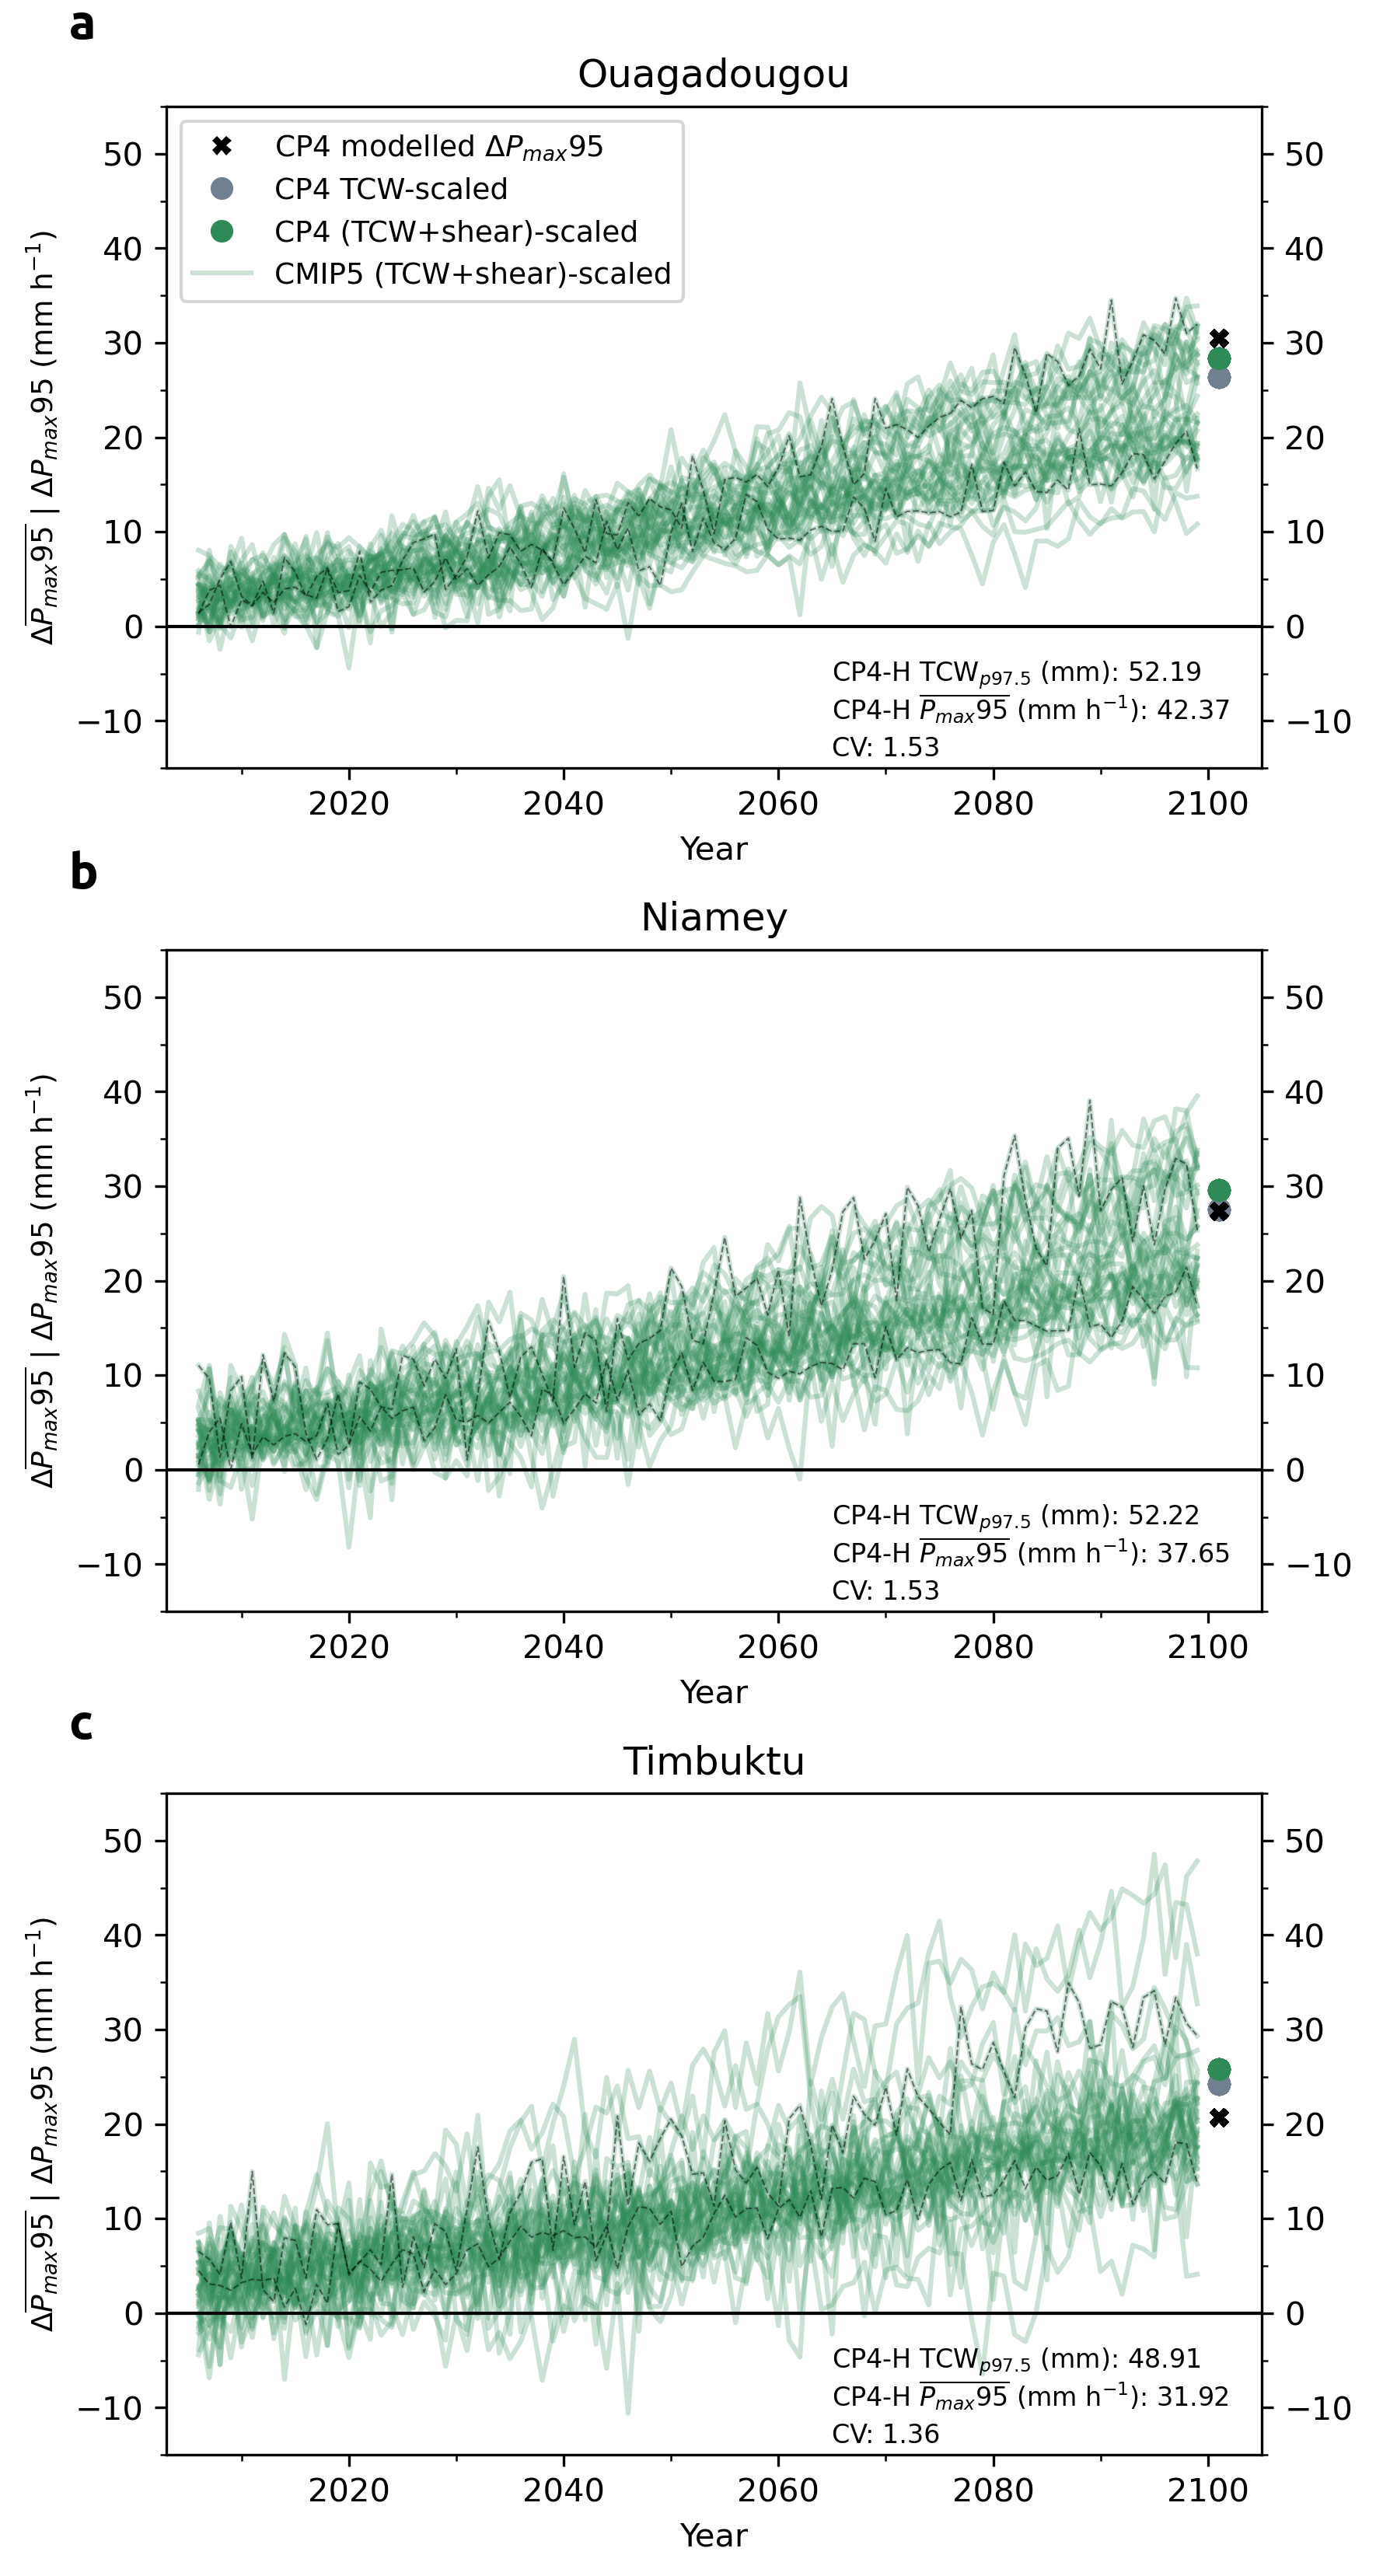

In [86]:
sahel = [-10,15,9,19]
x=2
ouaga=[-1.52-x,-1.52+x,11.38,13.38]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 12.51,14.51] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 15.77,17.77] #16.7666° N, 3.0026° W

regions = {'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu')}

f = plt.figure(figsize=(6,11), dpi=300)

for idss, rname in enumerate(['ouaga', 'niamey', 'timbuktu']):
    ax = f.add_subplot(3,1, idss+1)  #cp4f_mcs_grid-

    region = rname

    domain = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb")) #'+region+'

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['rel']) 
    precip_all = ftcw['prcp_hist']

    dirs = regions
    #cp4hist_mcs95, cp4fut_mcs95, obs_mcs95, cp4hist_mcs95_max, cp4fut_mcs95_max, obs_mcs95_max = calc_mcs(dirs[region][0])
    #cp4_tcw_hist, cp4_tcw_fut, cp4_tcw_rel, cp4_shear_abs = calc_regional(dirs[region][0])

    cp4_tcw_hist = cp4_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    cp4_tcw_fut = cp4f_tcw_onCmip['tcwv'].sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)
    
    cp4_shear_abs = ((cp4f_shear_onCmip['u_pl']-cp4_shear_onCmip['u_pl'])).sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    
    
    if rname=='niamey':
        c=1.5
    else:
        c=0
    cp4hist_mcs95 = cp4_mcs_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()-c
    cp4fut_mcs95 = cp4f_mcs_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    cp4hist_tcw95 = cp4_tcw_grid.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[2], domain[3])).mean().squeeze()
    isclose = np.nanargmin(np.abs(cp4hist_tcw95.values-ftcw['tcw_hist']))
    
#     cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(dirs[region][0])
#     isclose = np.nanargmin(np.abs(cp4hist_tcw95.values-ftcw['tcw_hist']))

    cp4_pos_array95 = tcwvfac_all[isclose]
    cp4_prcp_array95 = ftcw['prcp_hist'][isclose]
    cp4f_prcp_array95 = ftcw['prcp_fut'][isclose]

    slevels=np.arange(-18,19,3)

    yy ='2020-2100'

    #evenly_spaced_interval = np.linspace(0, 1, len(model_names))
    #colors = [cm.inferno(x) for x in evenly_spaced_interval]
    cmiplist = []
    cmipmean = []
    for ids, mn in enumerate(model_names.values):
        tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'_'+region+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
        sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'_'+region+'/u*_'+mn+'_*.nc')[0]).squeeze()

        tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
        sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)

        ##relative CMIP change
        ds_shear = sh_map['unknown']*shearfac
        cmip_rel = (tcw_map['prw'])

        years = np.unique(tcw_map['time.year'].values)

        new_ar_list95 = cmip_rel * 1.24
        sums95 = new_ar_list95 + ds_shear
        
        cp4construct95 =   cp4_tcw_rel.values *1.24

        cp4total95 = cp4construct95 + cp4_shear_abs*shearfac
        
        #ipdb.set_trace()
        
        cmiplist.append(sums95)
        cmipmean.append(np.mean(sums95[-30::]))
        model_Pmax = cp4fut_mcs95-cp4hist_mcs95+c

        ax.plot(2101, cp4fut_mcs95-cp4hist_mcs95, marker='X', linestyle='', mfc='k', label=r'CP4 modelled $\Delta P_{max}95$', zorder=99, mec='none')
        ax.plot(2101, cp4construct95, marker='o', linestyle='', color='slategrey', label=r'CP4 TCW-scaled')
        ax.plot(2101, cp4total95, marker='o', linestyle='', color='seagreen', label=r'CP4 (TCW+shear)-scaled')

        ax.plot(tcw_map['time.year'].values,sums95, color='seagreen', alpha=0.25, label=r'CMIP5 (TCW+shear)-scaled')
        if (idss==0) & (ids==0):
            plt.legend(fontsize=9, loc='upper left')
        #ipdb.set_trace()   
        if ids == 0:
            print('CP-combined', cp4total95)
            print('constr-model', cp4total95-(cp4fut_mcs95-cp4hist_mcs95) )
    meanordered = np.argsort(cmipmean)
    tsordered = np.array(cmiplist)[meanordered]
    pos90 = int(np.round(len(cmipmean)/100*90,0))
    pos10 = int(np.round(len(cmipmean)/100*10,0))
    
  
    ax.plot(tcw_map['time.year'].values,tsordered[pos10], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    ax.plot(tcw_map['time.year'].values,tsordered[pos90], color='k', alpha=0.5, linewidth=0.5, linestyle='dashed')
    
    print('CMIPPdifference', np.median(tsordered[pos90][-30::]), np.median(tsordered[pos90][-30::])-np.median(tsordered[pos10][-30::]))
    

    ax.text(2065,-5.8,'CP4-H TCW$_{p97.5}$ (mm): '+str(np.round(cp4hist_tcw95.values,2)), fontsize=8)
    ax.text(2065,-9.8,'CP4-H $\overline{P_{max}95}$ (mm h$^{-1}$): '+str(np.round(cp4hist_mcs95.values,2)), fontsize=8)
    ax.text(2065,-13.7,'CV: '+str(np.round(cp4_pos_array95,2)), fontsize=8)
    ax.set_ylabel('$\Delta \overline{P_{max}95}$ | $\Delta P_{max}95$ (mm h$^{-1}$)', fontsize=9)
    ax.set_xlabel('Year')
    ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    ax.set_ylim(-15,55)
    ax.set_xlim(2003,2105)
    ax.set_title(city)
    
plt.tight_layout()

text = ['a', 'b', 'c']
plt.tight_layout()
plt.annotate(text[0], xy=(0.05, 0.98), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[1], xy=(0.05, 0.65), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)
plt.annotate(text[2], xy=(0.05, 0.32), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=15)

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_all_cities_timeseries_CP4_0.1mm_sahel_fromMap.jpg')